In [73]:
#import packages
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as web

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Load Data
company = 'AMZN'

#Gather stock date of the past five years
start = dt.datetime(2016,1,1)
end = dt.datetime(2021,1,31)

#These date form YAHOO
df = web.DataReader(company, 'yahoo', start, end)

df.reset_index(inplace=True,drop=False)

#print the head
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-12-31,687.750000,675.890015,686.080017,675.890015,3749600,675.890015
1,2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990
2,2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978
3,2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024
4,2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002


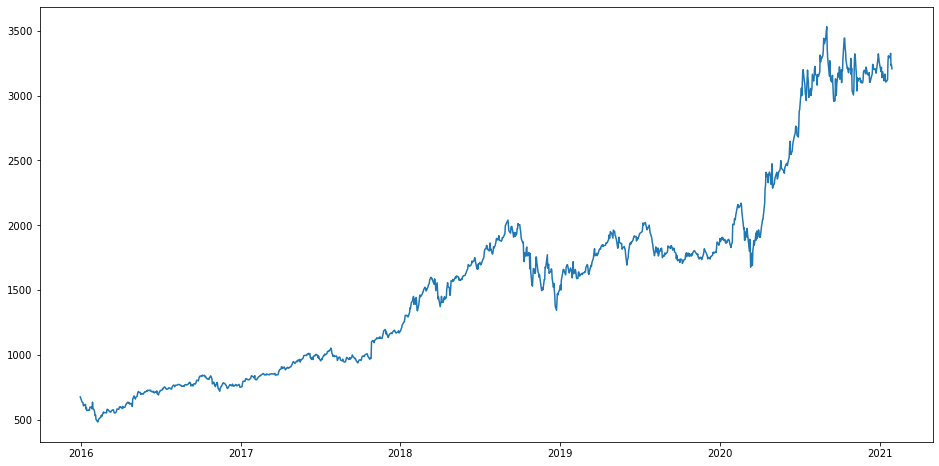

In [74]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [75]:
#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
#create features
from fastai.tabular import add_datepart
add_datepart(new_data, 'Date')
#elapsed will be the time stamp
new_data.drop('Elapsed', axis=1, inplace=True)

#split into train and validation
train = new_data[:1249]
valid = new_data[1249:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

In [76]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1249,:]
valid = dataset[1249:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#Load Test Data
prediction_days = 30

x_train, y_train = [], []
for i in range(prediction_days,len(train)):
    x_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting values, using past 30 from the train data
inputs = new_data[len(new_data) - len(valid) - prediction_days:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(prediction_days,inputs.shape[0]):
    X_test.append(inputs[i-prediction_days:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

 - 97s - loss: 0.0027


In [77]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

122.05709931104167

/Users/kejingli/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kejingli/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


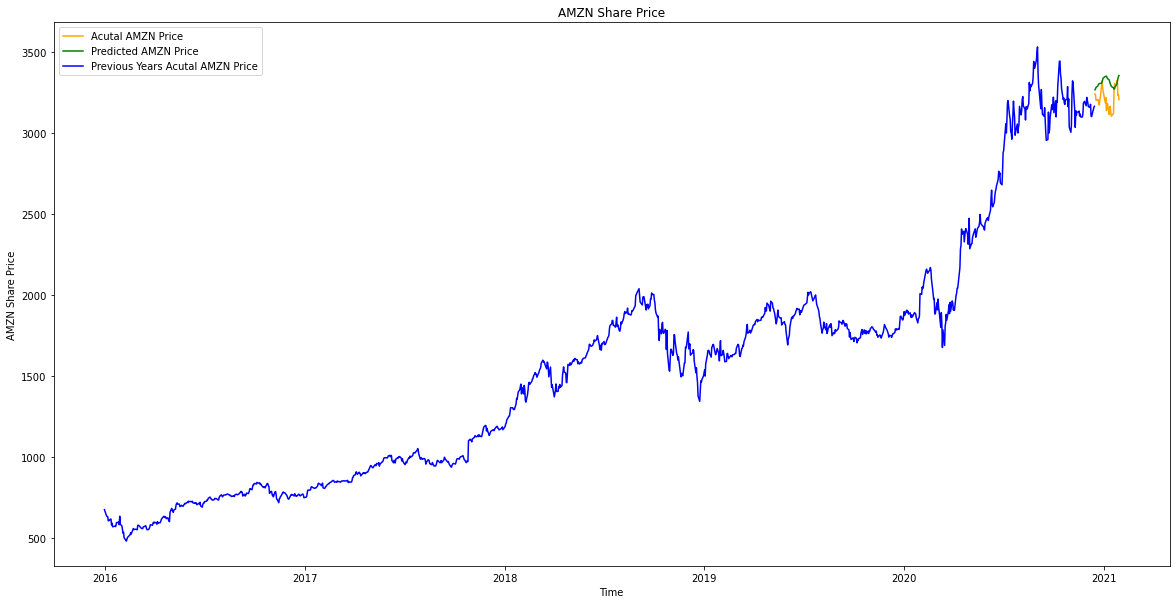

In [78]:
#for plotting
train = new_data[:1249]
valid = new_data[1249:]
valid.loc[:, 'Predictions'] = closing_price
plt.plot(valid.loc[:, 'Close'], color="orange", label=f"Acutal {company} Price")
plt.plot(valid.loc[:, 'Predictions'], color='green', label=f"Predicted {company} Price")
plt.plot(train.loc[:, 'Close'], color='blue', label=f"Previous Years Acutal {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()
#plt.plot(valid[['Close','Predictions']])

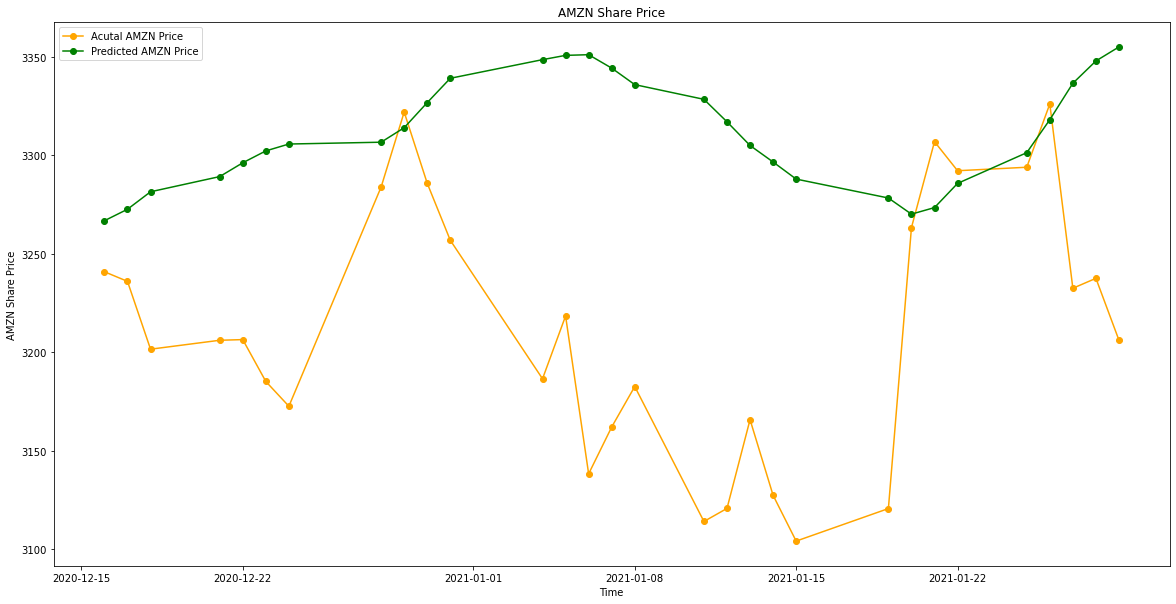

In [79]:
plt.plot(valid.loc[:, 'Close'], '-o', color="orange", label=f"Acutal {company} Price")
plt.plot(valid.loc[:, 'Predictions'], '-o', color='green', label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [81]:
n = inputs[len(inputs) - prediction_days:len(inputs+1), 0]
len(n)

30

In [82]:
real_data = [inputs[len(inputs) - prediction_days:len(inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

[[3356.8347]]


In [84]:
df = web.DataReader(company, 'yahoo', start = '2021-2-1', end  = '2021-2-1')
print(df['Close'])

Date
2021-02-01    3342.879883
Name: Close, dtype: float64
